In [1]:
import psycopg2
import pyreadr
import numpy as np
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import shap
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,plot_roc_curve,precision_recall_curve,PrecisionRecallDisplay
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
pd.options.mode.chained_assignment = None

In [2]:
dat = pyreadr.read_r('5v_cleandf.RData')
dat = dat['df']

In [3]:
# Sample data
dat.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4,40,Male,Hispanic or Latino,White or Caucasian,English,None,Single,Full Time,...,0,0,0,0,0,0,0,0,0,0
1,B,4,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
2,B,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
3,A,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
4,A,3,84,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,Retired,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Data information
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560486 entries, 0 to 560485
Columns: 972 entries, dep_name to cc_wristpain
dtypes: category(16), float64(753), int32(2), object(201)
memory usage: 4.0+ GB


In [5]:
# Data dimension
dat.shape

(560486, 972)

In [6]:
# Check missing percentage
percent_missing = (dat.isnull().sum() / len(dat)).to_frame()
percent_missing.columns = ['Missing percentage']
percent_missing.sort_values(by = 'Missing percentage', ascending=False,inplace=True)
percent_missing

,Missing percentage
"phencyclidine(pcp)screen,urine,noconf._median",1.000000
"phencyclidine(pcp)screen,urine,noconf._last",1.000000
"phencyclidine(pcp)screen,urine,noconf._max",1.000000
"phencyclidine(pcp)screen,urine,noconf._min",1.000000
"benzodiazepinesscreen,urine,noconf._last",0.999998
...,...
othcnsinfx,0.000000
othematldx,0.000000
othercvd,0.000000
othereardx,0.000000


In [7]:
# Drop columns with over 80% missing
dat.drop(list(percent_missing[percent_missing['Missing percentage']>0.8].index),axis=1,inplace=True)
dat.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4,40,Male,Hispanic or Latino,White or Caucasian,English,None,Single,Full Time,...,0,0,0,0,0,0,0,0,0,0
1,B,4,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
2,B,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
3,A,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
4,A,3,84,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,Retired,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Get numeric features
numeric_features = dat.select_dtypes(include=[np.number])
numeric_features.columns

Index(['2ndarymalig', 'abdomhernia', 'abdomnlpain', 'abortcompl', 'acqfootdef',
       'acrenlfail', 'acutecvd', 'acutemi', 'acutphanm', 'adjustmentdisorders',
       ...
       'meds_musclerelaxants', 'meds_pre-natalvitamins',
       'meds_psychotherapeuticdrugs', 'meds_sedative/hypnotics',
       'meds_skinpreps', 'meds_smokingdeterrents', 'meds_thyroidpreps',
       'meds_unclassifieddrugproducts', 'meds_vitamins', 'n_surgeries'],
      dtype='object', length=572)

In [9]:
# Change column data type
dat[dat.select_dtypes(include=['category']).columns] = dat[dat.select_dtypes(include=['category']).columns].astype(str)

In [10]:
# Get categorical features
categorical_features = dat.select_dtypes(include=[object])
categorical_features.columns

Index(['dep_name', 'esi', 'age', 'gender', 'ethnicity', 'race', 'lang',
       'religion', 'maritalstatus', 'employstatus',
       ...
       'cc_vaginaldischarge', 'cc_vaginalpain', 'cc_weakness', 'cc_wheezing',
       'cc_withdrawal-alcohol', 'cc_woundcheck', 'cc_woundinfection',
       'cc_woundre-evaluation', 'cc_wristinjury', 'cc_wristpain'],
      dtype='object', length=217)

In [11]:
# Convert age from object to numeric
dat['age'] = dat['age'].astype(np.number)

In [12]:
# Impute -1 to missing value
dat.fillna(value=-1,inplace=True)

In [13]:
# Convert categorical variables
dat[categorical_features.columns] = dat[categorical_features.columns].astype(str)
dat[categorical_features.columns] = dat[categorical_features.columns].apply(LabelEncoder().fit_transform)

In [14]:
# Feature selection
# Use feature importance from random forest
X = dat.drop(columns=['disposition'])
y = dat['disposition']

clf = RandomForestClassifier(n_estimators = 100, random_state=42).fit(X, y)
sel = SelectFromModel(clf,prefit=True)

In [15]:
# Get the number and list of selected features
selected_feat= X.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

185
Index(['dep_name', 'esi', 'age', 'gender', 'ethnicity', 'race', 'lang',
       'religion', 'maritalstatus', 'employstatus',
       ...
       'meds_vitamins', 'n_surgeries', 'cc_abdominalpain',
       'cc_alcoholintoxication', 'cc_alteredmentalstatus', 'cc_chestpain',
       'cc_neurologicproblem', 'cc_other', 'cc_psychiatricevaluation',
       'cc_shortnessofbreath'],
      dtype='object', length=185)


In [16]:
# Split into training, validation, and testing data (80%-10%-10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1/9, random_state=42)

In [17]:
# Logistic regression
clf = LogisticRegression(max_iter=1000) 
clf.fit(X_train[selected_feat], y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(max_iter=1000)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


Text(0.5, 1.0, 'Logistic Regression AUC Validation')

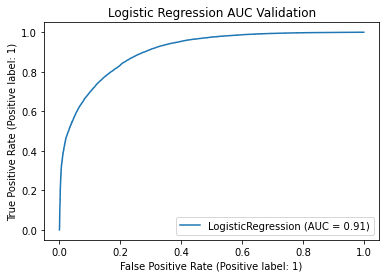

In [18]:
# AUC for logistic regression
plot_roc_curve(clf, X_valid[selected_feat], y_valid)
plt.title('Logistic Regression AUC Validation')

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


Text(0.5, 1.0, 'Logistic Regression AUC')

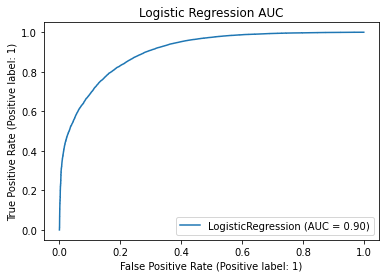

In [19]:
# AUC for logistic regression
plot_roc_curve(clf, X_test[selected_feat], y_test)
plt.title('Logistic Regression AUC')

Text(0.5, 1.0, 'Logistic Regression PR-AUC Validation')

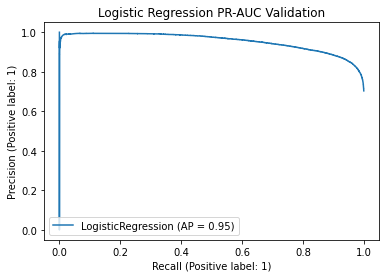

In [20]:
# PR AUC for logistic regression
PrecisionRecallDisplay.from_estimator(clf, X_valid[selected_feat], y_valid)
plt.title('Logistic Regression PR-AUC Validation')

Text(0.5, 1.0, 'Logistic Regression PR-AUC')

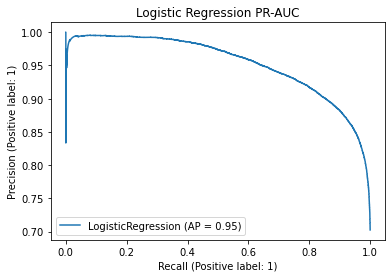

In [21]:
# PR AUC for logistic regression
PrecisionRecallDisplay.from_estimator(clf, X_test[selected_feat], y_test)
plt.title('Logistic Regression PR-AUC')

Text(0.5, 1.0, 'Logistic Regression Calibration Curve Valid')

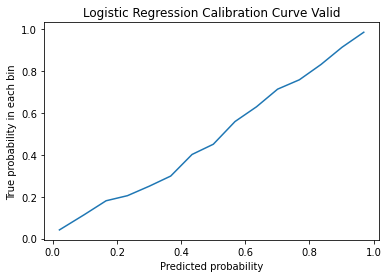

In [22]:
# Calibration curve for logistic regression
prob_true, prob_pred = calibration_curve(y_valid, clf.predict_proba(X_valid[selected_feat])[:,1], n_bins=15)
plt.plot(prob_pred,prob_true)
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Logistic Regression Calibration Curve Valid')

Text(0.5, 1.0, 'Logistic Regression Calibration Curve')

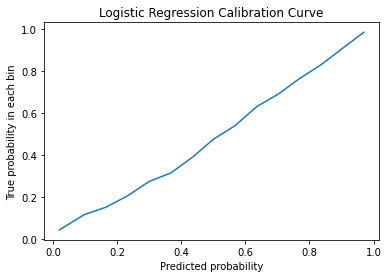

In [23]:
# Calibration curve for logistic regression
prob_true, prob_pred = calibration_curve(y_test, clf.predict_proba(X_test[selected_feat])[:,1], n_bins=15)
plt.plot(prob_pred,prob_true)
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Logistic Regression Calibration Curve')

In [34]:
# xgboost with hyperparameter tuning
# Create parameters dictionary
params = {
    'max_depth': [5, 10, 20],
    'reg_lambda': [0, 0.1, 1]}

model = XGBClassifier(random_state = 42)
best_score = 0.9

# Grid search
for g in ParameterGrid(params):
    
    model.set_params(**g)
    model.fit(X_train[selected_feat], y_train)
    score = roc_auc_score(y_valid,model.predict_proba(X_valid[selected_feat])[:,1])
    
    if score > best_score:
        best_score = score
        best_grid = g
        print("AUC:", best_score)
        print("Grid:", best_grid)

AUC: 0.9265142360566522
Grid: {'max_depth': 5, 'reg_lambda': 0}
AUC: 0.927066805849653
Grid: {'max_depth': 5, 'reg_lambda': 0.1}
AUC: 0.9273829463119118
Grid: {'max_depth': 5, 'reg_lambda': 1}


In [24]:
# xgboost
model = XGBClassifier(random_state = 42, max_depth=5, reg_lambda=1)
model.fit(X_train[selected_feat], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


Text(0.5, 1.0, 'xgboost AUC Validation')

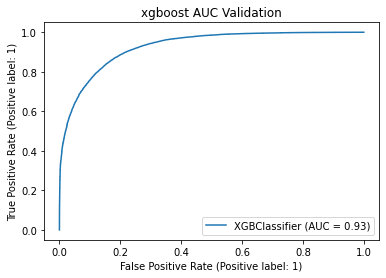

In [25]:
# AUC for xgboost
plot_roc_curve(model, X_valid[selected_feat], y_valid)
plt.title('xgboost AUC Validation')

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


Text(0.5, 1.0, 'xgboost AUC')

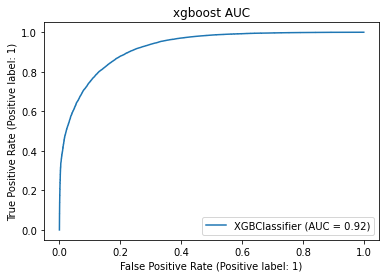

In [26]:
# AUC for xgboost
plot_roc_curve(model, X_test[selected_feat], y_test)
plt.title('xgboost AUC')

Text(0.5, 1.0, 'xgboost PR-AUC Validation')

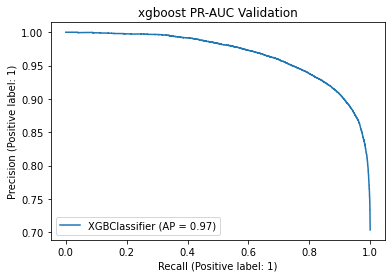

In [27]:
# PR AUC for xgboost
PrecisionRecallDisplay.from_estimator(model, X_valid[selected_feat], y_valid)
plt.title('xgboost PR-AUC Validation')

Text(0.5, 1.0, 'xgboost PR-AUC')

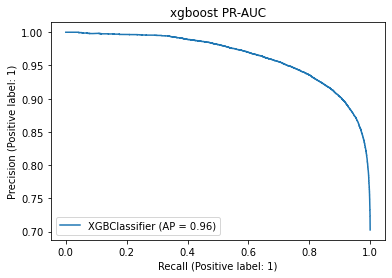

In [28]:
# PR AUC for xgboost
PrecisionRecallDisplay.from_estimator(model, X_test[selected_feat], y_test)
plt.title('xgboost PR-AUC')

Text(0.5, 1.0, 'xgboost Calibration Curve Validation')

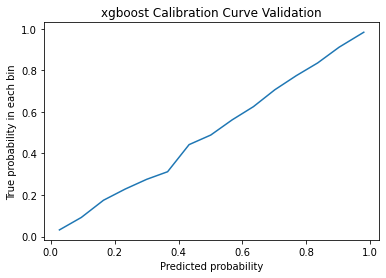

In [29]:
# Calibration curve for xgboost
prob_true, prob_pred = calibration_curve(y_valid, model.predict_proba(X_valid[selected_feat])[:,1], n_bins=15)
plt.plot(prob_pred,prob_true)
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('xgboost Calibration Curve Validation')

Text(0.5, 1.0, 'xgboost Calibration Curve')

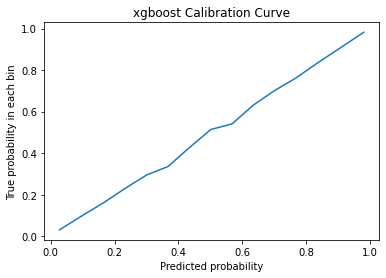

In [30]:
# Calibration curve for xgboost
prob_true, prob_pred = calibration_curve(y_test, model.predict_proba(X_test[selected_feat])[:,1], n_bins=15)
plt.plot(prob_pred,prob_true)
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('xgboost Calibration Curve')

In [38]:
# Odds ratio for top 10 variables of importance
odds_ratio = pd.DataFrame(clf.feature_names_in_,columns=["feature"])
odds_ratio["odds_ratio"] = np.exp(clf.coef_[0])
odds_ratio.sort_values(by =["odds_ratio"], ascending=False)[0:10]

,feature,odds_ratio
1,esi,3.200151
178,cc_alcoholintoxication,1.416240
23,hyperlipidem,1.169736
17,asthma,1.100964
47,rbc_last,1.084050
10,insurance_status,1.074210
21,esophgealdx,1.068772
16,anxietydisorders,1.064619
0,dep_name,1.060855
122,rbc_median,1.060163


In [31]:
# SHAP summary plot, feature importance with top 20 variables 
# 200 random rows in X_test
X_test.reset_index(drop=True,inplace=True)
indices = random.sample(range(0, len(X_test)), 200)
# Fits the explainer
explainer = shap.TreeExplainer(model)
# Calculates the SHAP values
shap_values = explainer.shap_values(X_test.loc[indices,selected_feat])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


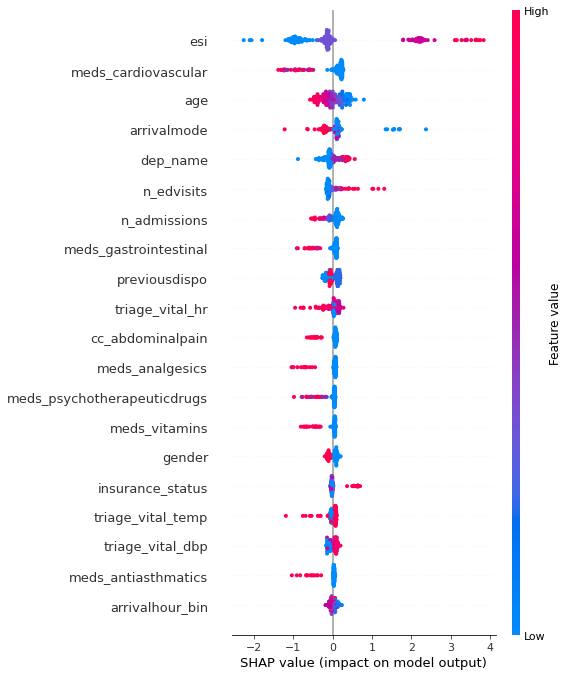

In [32]:
shap.summary_plot(shap_values,X_test.loc[indices,selected_feat],max_display=20)

In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0:5], X_test.loc[0:5,selected_feat])

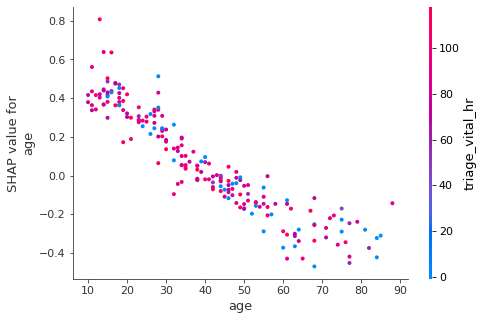

In [178]:
shap.dependence_plot("age", shap_values, X_test.loc[indices,selected_feat],interaction_index="triage_vital_hr")

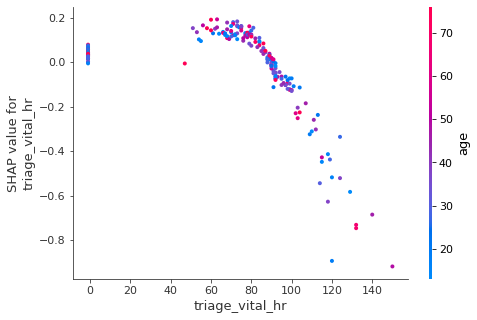

In [179]:
shap.dependence_plot("triage_vital_hr", shap_values, X_test.loc[indices,selected_feat],interaction_index="age")